In [1]:
%run util.py

data_folder = '/home/jzh/Waze/'

import csv
import json

# Loading JSON data
with open(data_folder + 'points_dict_Mar16.json', 'r') as json_file:
    points_dict = json.load(json_file)

# ### Extract jam data for a typical workday, say, March 9, 2016 (Wednesday)
# The features we are going to use are: 
# (longitude, latitude), numPts, speed, delay, length, startTime.

# Note that "(longitude, latitude), numPts" are from the points data.

# Convert "startTime" to seconds, discarding the date stamp.

from geopy.distance import vincenty

In [2]:
def extractRefandTestData(radius, numPtThres):
    ##### cf. http://www.latlong.net/
    BU = (42.351848, -71.110730)

    with open(data_folder + 'raw_data/waze_jams.csv', 'rb') as csvfile:
        reader = csv.DictReader(csvfile)
        i = 0
        jam_ref_data = {}

        for row in reader:
    #         print(row.keys())
            # print(row['street'])
            if ('2016-03-09' in row['startTime']):
                pt = (points_dict[row['uuid']][0][0][1], points_dict[row['uuid']][0][0][0])
                # If the number of points in a jam is less than numPtThres, we roughly take this jam as "normal"
                if (vincenty(BU, pt).meters < radius and points_dict[row['uuid']][1] < numPtThres):
    #             if (vincenty(BU, pt).meters < 5e3):
                    key = str(i)
                    data = {'uuid': row['uuid'],
                            'longitude_latitude': points_dict[row['uuid']][0],
                            'numPts': points_dict[row['uuid']][1], 
                            'speed': float(row['speed']), 
                            'delay': float(row['delay']),
                            'length': float(row['Length']), 
                            'startTime': convStartTimeToSec(row['startTime'])}
                    jam_ref_data[key] = data
                    i += 1
#     print(i)

    # Writing JSON data
    with open(data_folder + 'jam_ref_data.json', 'w') as json_file:
        json.dump(jam_ref_data, json_file)

    with open(data_folder + 'raw_data/waze_jams.csv', 'rb') as csvfile:
        reader = csv.DictReader(csvfile)
        i = 0
        jam_test_data = {}
        for row in reader:
    #         print(row.keys())
            # print(row['street'])
            if ('2016-03-16' in row['startTime']):
                pt = (points_dict[row['uuid']][0][0][1], points_dict[row['uuid']][0][0][0])
                if (vincenty(BU, pt).meters < radius):
    #             print(row['uuid'], row['street'], row['endNode'], row['roadType'], row['speed'], row['delay'], 
    #             row['Length'], row['startTime'], row['endTime'], row['\xef\xbb\xbfinject_date'])
                    key = str(i)
                    data = {'uuid': row['uuid'],
                            'longitude_latitude': points_dict[row['uuid']][0],
                            'numPts': points_dict[row['uuid']][1], 
                            'speed': float(row['speed']), 
                            'delay': float(row['delay']),
                            'length': float(row['Length']), 
                            'startTime': convStartTimeToSec(row['startTime'])}
                    jam_test_data[key] = data
                    i += 1
#     print(i)

    # Writing JSON data
    with open(data_folder + 'jam_test_data.json', 'w') as json_file:
        json.dump(jam_test_data, json_file)

In [3]:
def QuantRefandTestTraffic(loc_k, num_core, length_k, numPts_k, speed_k, delay_k, flag):
    # Loading JSON data
    with open(data_folder + 'jam_ref_data.json', 'r') as json_file:
        jam_ref_data = json.load(json_file)

    with open(data_folder + 'jam_test_data.json', 'r') as json_file:
        jam_test_data = json.load(json_file)

    ### Quantize the features by k-means clustering

    ### Quantize the features by k-means clustering 

    import numpy as np

    loc_list = []
    length_list = []
    numPts_list = []
    speed_list = []
    delay_list = []

    ref_loc_list = []
    ref_length_list = []
    ref_numPts_list = []
    ref_speed_list = []
    ref_delay_list = []
    for key in jam_ref_data.keys():
        ref_loc_list.append(jam_ref_data[key]['longitude_latitude'])
        loc_list.append(jam_ref_data[key]['longitude_latitude'])

        ref_length_list.append(jam_ref_data[key]['length'])
        length_list.append(jam_ref_data[key]['length'])

        ref_numPts_list.append(float(jam_ref_data[key]['numPts']))
        numPts_list.append(float(jam_ref_data[key]['numPts']))

        ref_speed_list.append(jam_ref_data[key]['speed'])
        speed_list.append(jam_ref_data[key]['speed'])

        ref_delay_list.append(jam_ref_data[key]['delay'])
        delay_list.append(jam_ref_data[key]['delay'])

    test_loc_list = []
    test_length_list = []
    test_numPts_list = []
    test_speed_list = []
    test_delay_list = []
    for key in jam_test_data.keys():
        test_loc_list.append(jam_test_data[key]['longitude_latitude'])
        loc_list.append(jam_test_data[key]['longitude_latitude'])

        test_length_list.append(jam_test_data[key]['length'])
        length_list.append(jam_test_data[key]['length'])

        test_numPts_list.append(float(jam_test_data[key]['numPts']))
        numPts_list.append(float(jam_test_data[key]['numPts']))

        test_speed_list.append(jam_test_data[key]['speed'])
        speed_list.append(jam_test_data[key]['speed'])
        
        test_delay_list.append(jam_test_data[key]['delay'])
        delay_list.append(jam_test_data[key]['delay'])

    loc_data = loc_list
    length_data = np.array(length_list)
    numPts_data = np.array(numPts_list)
    speed_data = np.array(speed_list)
    delay_data = np.array(delay_list)

#     len(loc_data), len(ref_loc_list), len(test_loc_list)

    ### Quantization levels: loc_k = 3, length_k = 2, numPts_k = 1, speed_k = 2

    loc_data = [list(np.reshape(loc_data[i], np.size(loc_data[i]))) for i in range(len(loc_data))]

    from scipy.cluster.vq import kmeans2
    from ClusterAlg import DF, KMedians

    loc_label, loc_centroid, distToClusterCenter = KMedians(loc_data, loc_k, num_core, DF)

    length_centroid, length_label = kmeans2(length_data, length_k, iter=300, thresh=1e-06, minit='random', missing='warn', check_finite=True)

    numPts_centroid, numPts_label = kmeans2(numPts_data, numPts_k, iter=300, thresh=1e-06, minit='random', missing='warn', check_finite=True)

    speed_centroid, speed_label = kmeans2(speed_data, speed_k, iter=300, thresh=1e-06, minit='random', missing='warn', check_finite=True)
    
    delay_centroid, delay_label = kmeans2(delay_data, delay_k, iter=300, thresh=1e-06, minit='random', missing='warn', check_finite=True)

    ref_loc_label = loc_label[0:np.size(np.array(ref_loc_list),0)]
    test_loc_label = loc_label[np.size(np.array(ref_loc_list),0):np.size(loc_data,0)]

    ref_length_label = length_label[0:np.size(np.array(ref_length_list),0)]
    test_length_label = length_label[np.size(np.array(ref_length_list),0):np.size(length_data,0)]

    ref_numPts_label = numPts_label[0:np.size(np.array(ref_numPts_list),0)]
    test_numPts_label = numPts_label[np.size(np.array(ref_numPts_list),0):np.size(numPts_data,0)]
    
    ref_speed_label = speed_label[0:np.size(np.array(ref_speed_list),0)]
    test_speed_label = speed_label[np.size(np.array(ref_speed_list),0):np.size(speed_data,0)]

    ref_delay_label = delay_label[0:np.size(np.array(ref_delay_list),0)]
    test_delay_label = delay_label[np.size(np.array(ref_delay_list),0):np.size(delay_data,0)]

    quantized_jam_ref_data = {}

    i = 0
    for key in jam_ref_data.keys():
        data = {'uuid': jam_ref_data[key]['uuid'],
                'longitude_latitude': jam_ref_data[key]['longitude_latitude'],
                'length': jam_ref_data[key]['length'],
                'numPts': float(jam_ref_data[key]['numPts']),
                'speed': jam_ref_data[key]['speed'],
                'delay': jam_ref_data[key]['delay'],
                'startTime': jam_ref_data[key]['startTime'],
                'loc_label': float(ref_loc_label[i]),
                'length_label': float(ref_length_label[i]),
                'numPts_label': float(ref_numPts_label[i]),
                'speed_label': float(ref_speed_label[i]),
                'delay_label': float(ref_delay_label[i])}
        quantized_jam_ref_data[key] = data
        i += 1

    # Writing JSON data
    with open(data_folder + 'quantized_jam_ref_data_%s.json'%flag, 'w') as json_file:
        json.dump(quantized_jam_ref_data, json_file)

    quantized_jam_test_data = {}

    i = 0
    for key in jam_test_data.keys():
        data = {'uuid': jam_test_data[key]['uuid'],
                'longitude_latitude': jam_test_data[key]['longitude_latitude'],
                'length': jam_test_data[key]['length'],
                'numPts': float(jam_test_data[key]['numPts']),
                'speed': jam_test_data[key]['speed'],
                'delay': jam_test_data[key]['delay'],
                'startTime': jam_test_data[key]['startTime'],
                'loc_label': float(test_loc_label[i]),
                'length_label': float(test_length_label[i]),
                'numPts_label': float(test_numPts_label[i]),
                'speed_label': float(test_speed_label[i]),
                'delay_label': float(test_delay_label[i])}
        quantized_jam_test_data[key] = data
        i += 1

    # Writing JSON data
    with open(data_folder + 'quantized_jam_test_data_%s.json'%flag, 'w') as json_file:
        json.dump(quantized_jam_test_data, json_file)
    return distToClusterCenter, loc_label, loc_centroid

In [4]:
def Mapping_features_in_ref_and_test_traffic_to_alphabet(loc_k, length_k, numPts_k, speed_k, delay_k, flag):
    
    # Loading JSON data
    with open(data_folder + 'quantized_jam_ref_data_%s.json'%flag, 'r') as json_file:
        quantized_jam_ref_data = json.load(json_file)

    with open(data_folder + 'quantized_jam_test_data_%s.json'%flag, 'r') as json_file:
        quantized_jam_test_data = json.load(json_file)

    ##### Create the finite alphabet
    alphabet = {}

    i = 0
    for loc_label in range(loc_k):
        for length_label in range(length_k):
            for numPts_label in range(numPts_k):
                for speed_label in range(speed_k):
                    for delay_label in range(delay_k):
                        key = str((float(loc_label), float(length_label), float(numPts_label), float(speed_label), float(delay_label)))
                        alphabet[key] = float(i)
                        i += 1

    alphabet_trans = {}

    L = len(alphabet)
    i = 0
    for l in range(L):
        for m in range(L):
            key = str((float(l), float(m)))
            alphabet_trans[key] = float(i)
            i += 1

    ### Mapping features to the alphabet

    sample_path_jam_ref_data = {}

    i = 0
    for key in quantized_jam_ref_data.keys():
        alpha_key = str((quantized_jam_ref_data[key]['loc_label'], \
                     quantized_jam_ref_data[key]['length_label'], \
                     quantized_jam_ref_data[key]['numPts_label'], \
                     quantized_jam_ref_data[key]['speed_label'], \
                     quantized_jam_ref_data[key]['delay_label']))
        data = {'uuid': quantized_jam_ref_data[key]['uuid'],
                'startTime': quantized_jam_ref_data[key]['startTime'] + 0.0001 * i,
                'numPts': quantized_jam_ref_data[key]['numPts'],
                'length': quantized_jam_ref_data[key]['length'],
                'speed': quantized_jam_ref_data[key]['speed'],
                'delay': quantized_jam_ref_data[key]['delay'],
                'alpha': alphabet[alpha_key]}
        sample_path_jam_ref_data[key] = data
        i += 1

    len_sample_path_jam_ref_data = len(sample_path_jam_ref_data)

    sample_path_jam_ref_data_sorted = {}
    for i in range(len_sample_path_jam_ref_data):
        key = str(i)
        sample_path_jam_ref_data_sorted[key] = sorted(sample_path_jam_ref_data.items(), key=lambda x: x[1]['startTime'])[i][1]

    # Writing JSON data
    with open(data_folder + 'sample_path_jam_ref_data_sorted_%s.json'%flag, 'w') as json_file:
        json.dump(sample_path_jam_ref_data_sorted, json_file)

    sample_path_jam_ref_data_sorted_trans = {} 

    for i in range(len_sample_path_jam_ref_data)[:-1]:
        key = str(i)
        key_ = str(i+1)
        alphabet_trans_key = str((sample_path_jam_ref_data_sorted[key]['alpha'], sample_path_jam_ref_data_sorted[key_]['alpha']))
        data = {'alphaTrans': alphabet_trans[alphabet_trans_key],
                'startTime': sample_path_jam_ref_data_sorted[key]['startTime'],
                'uuid': (sample_path_jam_ref_data_sorted[key]['uuid'], sample_path_jam_ref_data_sorted[key_]['uuid'])}
        sample_path_jam_ref_data_sorted_trans[key] = data

    # Writing JSON data
    with open(data_folder + 'sample_path_jam_ref_data_sorted_trans_%s.json'%flag, 'w') as json_file:
        json.dump(sample_path_jam_ref_data_sorted_trans, json_file)


    sample_path_jam_test_data = {}

    i = 0
    for key in quantized_jam_test_data.keys():
        alpha_key = str((quantized_jam_test_data[key]['loc_label'], \
                     quantized_jam_test_data[key]['length_label'], \
                     quantized_jam_test_data[key]['numPts_label'], \
                     quantized_jam_test_data[key]['speed_label'], \
                     quantized_jam_test_data[key]['delay_label']))
        data = {'uuid': quantized_jam_test_data[key]['uuid'],
                'startTime': quantized_jam_test_data[key]['startTime'] + 0.0001 * i,
                'numPts': quantized_jam_test_data[key]['numPts'],
                'length': quantized_jam_test_data[key]['length'],
                'speed': quantized_jam_test_data[key]['speed'],
                'delay': quantized_jam_test_data[key]['delay'],
                'alpha': alphabet[alpha_key]}
        sample_path_jam_test_data[key] = data
        i += 1

    len_sample_path_jam_test_data = len(sample_path_jam_test_data)

    sample_path_jam_test_data_sorted = {}
    for i in range(len_sample_path_jam_test_data):
        key = str(i)
        sample_path_jam_test_data_sorted[key] = sorted(sample_path_jam_test_data.items(), key=lambda x: x[1]['startTime'])[i][1]

    # Writing JSON data
    with open(data_folder + 'sample_path_jam_test_data_sorted_%s.json'%flag, 'w') as json_file:
        json.dump(sample_path_jam_test_data_sorted, json_file)

    sample_path_jam_test_data_sorted_trans = {} 

    for i in range(len_sample_path_jam_test_data)[:-1]:
        key = str(i)
        key_ = str(i+1)
        alphabet_trans_key = str((sample_path_jam_test_data_sorted[key]['alpha'], sample_path_jam_test_data_sorted[key_]['alpha']))
        data = {'alphaTrans': alphabet_trans[alphabet_trans_key],
                'startTime': sample_path_jam_test_data_sorted[key]['startTime'],
                'uuid': (sample_path_jam_test_data_sorted[key]['uuid'], sample_path_jam_test_data_sorted[key_]['uuid'])}
        sample_path_jam_test_data_sorted_trans[key] = data

    # Writing JSON data
    with open(data_folder + 'sample_path_jam_test_data_sorted_trans_%s.json'%flag, 'w') as json_file:
        json.dump(sample_path_jam_test_data_sorted_trans, json_file)

In [5]:
def Estimate_PLs_from_ref_traffic(loc_k, length_k, numPts_k, speed_k, delay_k, flag):
    # Loading JSON data
    with open(data_folder + 'sample_path_jam_ref_data_sorted_trans_%s.json'%flag, 'r') as json_file:
        sample_path_jam_ref_data = json.load(json_file)

    with open(data_folder + 'sample_path_jam_test_data_sorted_trans_%s.json'%flag, 'r') as json_file:
        sample_path_jam_test_data = json.load(json_file)

    # ### Divide a typical workday into four intervals

    # 5:00-10:00 (AM) => [18000, 36000)

    # 10:00-15:00 (MD) => [36000, 54000)

    # 15:00-19:00 (PM) => [54000, 68400)

    # 19:00-5:00 (NT) => [0, 18000) or [68400, 86400)

    ##### Estimate PLs from sample_path_jam_ref_data
    sample_path_jam_ref_data_ = []
    sample_path_jam_ref_data_AM = []
    sample_path_jam_ref_data_MD = []
    sample_path_jam_ref_data_PM = []
    sample_path_jam_ref_data_NT = []

    for i in range(len(sample_path_jam_ref_data.keys())):
        key = str(i)
        sample_path_jam_ref_data_.append(int(sample_path_jam_ref_data[key]['alphaTrans']))
        if (sample_path_jam_ref_data[key]['startTime'] >= 18000 and \
            sample_path_jam_ref_data[key]['startTime'] < 36000):
            sample_path_jam_ref_data_AM.append(int(sample_path_jam_ref_data[key]['alphaTrans']))
        elif (sample_path_jam_ref_data[key]['startTime'] >= 36000 and \
            sample_path_jam_ref_data[key]['startTime'] < 54000):
            sample_path_jam_ref_data_MD.append(int(sample_path_jam_ref_data[key]['alphaTrans']))
        elif (sample_path_jam_ref_data[key]['startTime'] >= 54000 and \
            sample_path_jam_ref_data[key]['startTime'] < 68400):
            sample_path_jam_ref_data_PM.append(int(sample_path_jam_ref_data[key]['alphaTrans']))
        else:
            sample_path_jam_ref_data_NT.append(int(sample_path_jam_ref_data[key]['alphaTrans']))

    assert(len(sample_path_jam_ref_data_AM) + \
    len(sample_path_jam_ref_data_MD) + \
    len(sample_path_jam_ref_data_PM) + \
    len(sample_path_jam_ref_data_NT) == len(sample_path_jam_ref_data_))

    N = loc_k * length_k * numPts_k * speed_k * delay_k
    PL = mu_est(sample_path_jam_ref_data_, N)
    PL_AM = mu_est(sample_path_jam_ref_data_AM, N)
    PL_MD = mu_est(sample_path_jam_ref_data_MD, N)
    PL_PM = mu_est(sample_path_jam_ref_data_PM, N)
    PL_NT = mu_est(sample_path_jam_ref_data_NT, N)

    PL_dict = {}
    PL_dict['PL'] = PL
    PL_dict['PL_AM'] = PL_AM
    PL_dict['PL_MD'] = PL_MD
    PL_dict['PL_PM'] = PL_PM
    PL_dict['PL_NT'] = PL_NT

    # Saving PL data
    zdump(PL_dict, data_folder + 'PL_dict_%s.pkz'%flag) 

    KL_est(sample_path_jam_ref_data_, PL_AM)

    np.size(PL, 0), np.size(PL, 1)

    sample_path_jam_ref_data_

In [6]:
def Anomaly_detection(beta, sam_gap, win_size, flag):
    # Loading PL data
    PL_dict = zload(data_folder + 'PL_dict_%s.pkz'%flag) 

    # PL_dict

    mu_1 = PL_dict['PL_AM']  # normal PL for AM period
    mu_2 = PL_dict['PL_MD']  # normal PL for MD period
    mu_3 = PL_dict['PL_PM']  # normal PL for PM period
    mu_4 = PL_dict['PL_NT']  # normal PL for NT period

    mu_1 = mu_adjust(mu_1)  # normal PL
    mu_01, mu1, mu_11, P1, G_11, H_11, U_11 = ChainGen_(mu_1)

    mu_2 = mu_adjust(mu_2)  # normal PL
    mu_02, mu2, mu_12, P2, G_12, H_12, U_12 = ChainGen_(mu_2)

    mu_3 = mu_adjust(mu_3)  # normal PL
    mu_03, mu3, mu_13, P3, G_13, H_13, U_13 = ChainGen_(mu_3)

    mu_4 = mu_adjust(mu_4)  # normal PL
    mu_04, mu4, mu_14, P4, G_14, H_14, U_14 = ChainGen_(mu_4)

#     beta = 1e-6
    G_list = [G_11, G_12, G_13, G_14]
    H_list = [H_11, H_12, H_13, H_14]
    U_list = [U_11, U_12, U_13, U_14]

    eta_wc = {}
    eta_Sanov = {}

    # Get thresholds for Hoeffding's test corresponding to sample length n  
    def etaWC(n):
        return HoeffdingRuleMarkovRobust_(beta, G_list, H_list, U_list, n)

    # Loading test data

    with open(data_folder + 'sample_path_jam_test_data_sorted_trans_%s.json'%flag, 'r') as json_file:
        sample_path_jam_test_data_sorted_trans = json.load(json_file)

#     sample_path_jam_test_data_sorted_trans['0']

    i = 0  # index of windows
#     sam_gap = 120
#     win_size = 600
    win_list = []
    while i * sam_gap + win_size < 24 * 3600:
        win_list.append((i * sam_gap, i * sam_gap + win_size))
        i += 1

#     i

    win_num = len(win_list)
    jam_num = len(sample_path_jam_test_data_sorted_trans)

    win_jam = {}
    for i in range(win_num):
        key = str(i)
        value = []
        for j in range(jam_num):
            if ((sample_path_jam_test_data_sorted_trans[str(j)]['startTime'] >= win_list[i][0]) \
                and (sample_path_jam_test_data_sorted_trans[str(j)]['startTime'] < win_list[i][1])):
                value.append(str(j))
        win_jam[key] = value

#     win_jam['714'], win_list[714][0], win_num 

#     sample_path_jam_test_data_sorted_trans[win_jam['100'][0]]['startTime']

    KL_list = []  # The list of the KL divergences; each is for a detection window
    etaWC_list = []
    for i in range(win_num):
        sample_path_jam = [sample_path_jam_test_data_sorted_trans[key]['alphaTrans'] for key in win_jam[str(i)]]
        n = len(sample_path_jam)
        if (n != 0):
            etaWC_list.append(etaWC(n))
            KL_1 = KL_est(sample_path_jam, mu_1)
            KL_2 = KL_est(sample_path_jam, mu_2)
            KL_3 = KL_est(sample_path_jam, mu_3)
            KL_4 = KL_est(sample_path_jam, mu_4)
            KL_list.append(min([KL_1, KL_2, KL_3, KL_4]))
        else:
            etaWC_list.append(1e-6)
            KL_list.append(0)

#     win_jam[str(100)], win_list[100][1]

    %matplotlib inline
    
    # cf. https://codeyarns.com/2014/10/27/how-to-change-size-of-matplotlib-plot/
    # Get current size
    fig_size = plt.rcParams['figure.figsize']

    # Set figure width to 12.0 and height to 6.0
    fig_size[0] = 12.0
    fig_size[1] = 6.0
    plt.rcParams['figure.figsize'] = fig_size

    time_range = [win_list[i][0] / 60.0 for i in range(win_num)]
    plot_points(time_range, KL_list, etaWC_list)
    plt.ylabel('divergence')
    plt.xlabel('time (min)')
    pylab.ylim(-0.1, max(etaWC_list)+0.5)
    pylab.xlim(0, max(time_range)+10)
    plt.savefig(data_folder + 'detec_results_WC_robust_%s.pdf'%flag)
    return time_range, KL_list, etaWC_list, win_jam

In [7]:
def run(para_dict):
    extractRefandTestData(para_dict['radius'], para_dict['numPtThres'])

    distToClusterCenter, loc_label, loc_centroid = QuantRefandTestTraffic(para_dict['loc_k'], \
                                                                          para_dict['num_core'], \
                                                                          para_dict['length_k'], \
                                                                          para_dict['numPts_k'], \
                                                                          para_dict['speed_k'], \
                                                                          para_dict['delay_k'], \
                                                                          para_dict['flag'])

    Mapping_features_in_ref_and_test_traffic_to_alphabet(para_dict['loc_k'], para_dict['length_k'], \
                                                         para_dict['numPts_k'], para_dict['speed_k'], \
                                                         para_dict['delay_k'], para_dict['flag'])

    Estimate_PLs_from_ref_traffic(para_dict['loc_k'], para_dict['length_k'], para_dict['numPts_k'], \
                                  para_dict['speed_k'], para_dict['delay_k'], para_dict['flag'])

    time_range, KL_list, etaWC_list, win_jam = Anomaly_detection(para_dict['beta'], para_dict['sam_gap'], \
                                                                 para_dict['win_size'], para_dict['flag'])

    zdump(para_dict, data_folder + 'para_dict_%s.pkz'%(para_dict['flag']))
    zdump([distToClusterCenter, loc_label, loc_centroid], data_folder + 'loc_quant_results_%s.pkz'%(para_dict['flag']))
    zdump([time_range, KL_list, etaWC_list, win_jam], data_folder + 'detec_results_%s.pkz'%(para_dict['flag']))

In [8]:
para_dict_delay = {'radius':3e3, 'numPtThres':200000, 'loc_k':3, 'num_core':12, 'length_k':1, 'numPts_k':1, 'speed_k':1, \
             'delay_k':2, 'beta':1e-6, 'sam_gap':300, 'win_size':600, 'flag':'delay'}

para_dict_length = {'radius':3e3, 'numPtThres':200000, 'loc_k':3, 'num_core':12, 'length_k':2, 'numPts_k':1, 'speed_k':1, \
             'delay_k':1, 'beta':1e-6, 'sam_gap':300, 'win_size':600, 'flag':'length'}

<string>:492: RuntimeWarning: covariance is not positive-semidefinite.


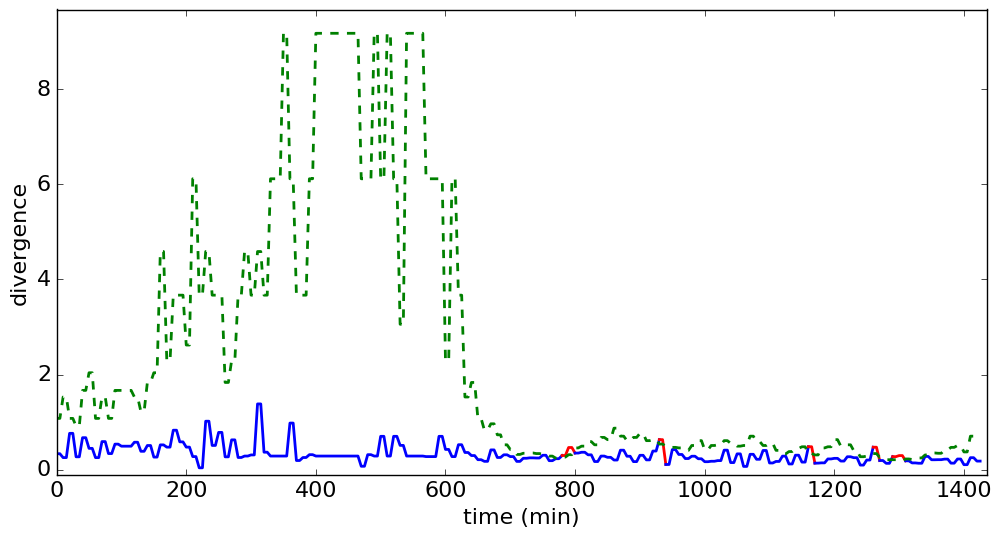

In [9]:
run(para_dict_delay)

/home/jzh/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


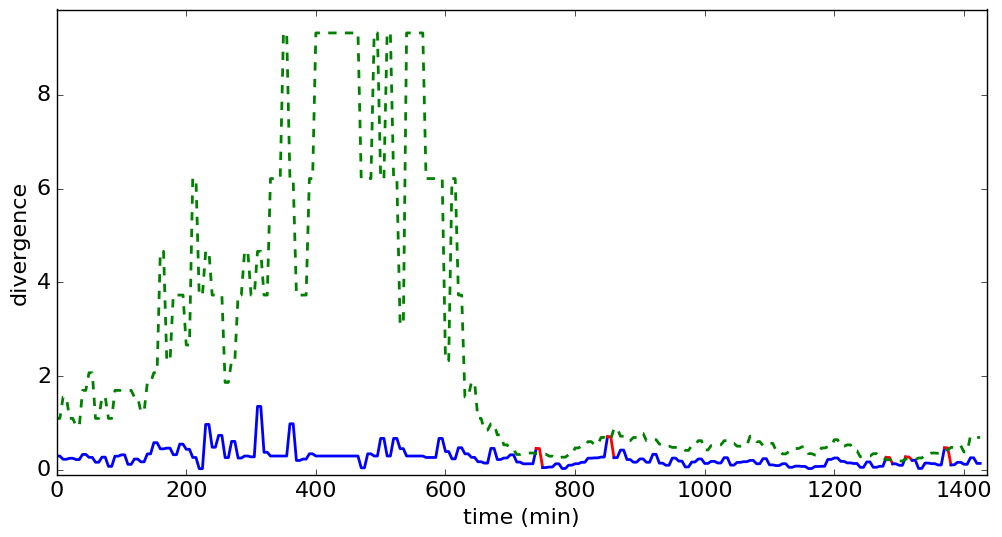

In [10]:
run(para_dict_length)